# CZ3006/CE3005 Assignment 1

## Import Libraries

In [1]:
!pip install plotly
import math
import random
from datetime import datetime
from math import factorial, log10, pow

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from numpy import exp

In [2]:
SAVE_TO_CSV = True
ORIGINAL_GRAPH_CSV_PATH = "protocols_generated_points_original.csv"
NEW_GRAPH_CSV_PATH = "protocols_generated_points_new.csv"

## Utils

In [3]:
# Global Variables
count = 0
NO_OF_DATAPOINTS = 0

def log_msg(message):
    time = datetime.now()
    print("[" + time.strftime("%Y-%m-%d %H:%M:%S") + "] " + str(message)); return time

def generate_datapoints(no_of_points, limit=100, degree_of_accuracy=5):
    step = limit/no_of_points
    x = [round(i, degree_of_accuracy) for i in np.arange(0, limit+step, step)]
    return x[1:]

def generate_log_datapoints(step, min_=0.01, limit_=100, degree_of_accuracy=5):
    start = log10(min_)
    end = log10(limit_) + step
    supercripts = list(np.arange(start, end, step))
    result = [round(10**supercript, degree_of_accuracy) for supercript in supercripts]
    return (result, len(result))

## Smallest precision possible for python's float datatype

In [4]:
i = 0
error_margin = 10
while (error_margin != 0):
    temp = i * -1
    error_margin = float(pow(10, temp))
    i += 1
print("Maximum precision of python float datatype is 10^-" + str(i-1))

ERROR_MARGIN = float(10E-324)
print(ERROR_MARGIN)

Maximum precision of python float datatype is 10^-324
1e-323


## Supporting Functions
**Dictionary:**  
**IRTD** : Initial Random Transmission Delay  
**TP** : Transmission Point  

**Notation Meanings:**  
**G** : Packets per transmission time T  
**a** : Normalized Propagation Delay/Slot size  
**p** : Probability that that transmission medium is idle (medium is ready for transmission)  

**T** : Transmission Time  
**N** : Number of packets accumulated at the end of a TP  
**N'** : Number of packets present at the beginning of a busy period, which is also the number of packets arriving in the last slot of the previous idle slot   
**q** : Prob that medium is busy, therefore continually listen until idle, calculated by 1-q  
**g** : Average arrival rate of new/rescheduled packets during a (mini) slot, calculated by a*G  


**J_i** : *ith* TP of a busy period  
**tn** : Number of slots elapsed until some packet is transmitted  
**tn'** : First inital random transmission delay of the busy period  
**Ln** : Number of packets present at the starting time of J_i  
**Ln-n** : Number of packets arriving during the gap, tn


**Traffic Model Assumptions:**  
1) Average transmission delay x_bar is large compared to T.  
2) Interarrival times of the point process defined by the start of all the packets plus retransmissions are independent and exponentially distributed.

In [5]:
# (25) Probability that number of packets accumulated at the end of a TP, N = n
# N = number of packets accumulated at the end of a TP 
def pi_n(G, n, a):
    assert n>=0
    
    # (50)
    if (a==0):
        numerator = pow(G, n)
        denominator = factorial(n)
        return numerator/denominator * exp(-G)
    
    var1 = exp((1+a)*-G)
    if (n==0):
        return var1
    return pow((1+a)*G, n)/factorial(n) * var1

# (26) Probability of 2 successive TP in same busy period after k slots have elapsed
# tn = number of slots elapsed until some packet is transmitted
# q = prob that medium is busy, therefore continually listen until idle
def prob_tn_more_than_k(G, n, k, a, p):
    g = a * G
    q = 1 - p
    
     # Special case when a==0
    if a==0:
        return pow(q, (k+1)*n)
    return pow(q, (k+1)*n) * exp(g*(q*(1-pow(q, k))/p - k))

# (27) Probability of 2 successive TP in same busy period after exactly k slots have elapsed
def prob_tn_equals_k(G, n, k, a, p):
    g = a * G 
    q = 1 - p 
    
    # (28) Special case when k==0
    if k==0:
        return 1 - pow(q, n)
    first_term = pow(q, k*n) * (1 - pow(q, n)*exp(-g*(1-pow(q, k))))
    second_term = exp(g*(q*(1-pow(q, k-1))/p - (k-1)))
    return first_term * second_term

# (29) Average IRTD
def t_bar_n(G, n, a, p):
    if a==0:
        q_n = exp(q, n)
        return q_n/(1-q_n)
    k = 0
    result = 0
    nxt_term = prob_tn_more_than_k(G, n, k, a=a, p=p)
    while (nxt_term > ERROR_MARGIN):
        try:
            nxt_term = prob_tn_more_than_k(G, n, k, a=a, p=p)
            result += nxt_term
            k += 1
        except:
            break
    return result

# (30) Average gap between 2 consecutive TPs in a busy period
def tbar(G, a, p):
    n = 1
    result = 0
    pi_n0 = pi_n(G, 0, a)
    nxt_term = t_bar_n(G, n, a, p) * (pi_n(G, n, a)/(1-pi_n0))
    while (nxt_term > ERROR_MARGIN):
        try:
            nxt_term = t_bar_n(G, n, a, p) * (pi_n(G, n, a)/(1-pi_n0))
            result += nxt_term
            n += 1
        except:
            break
    return result

# (31 | NOT USED) Prob that [Ln = l] given [tn=k]
# Ln = number of packets present at the starting time of J_i
# tn = number of slots elapsed until some packet is transmitted\
# Ln - n = Number of packets arriving during the gap, tn
def prob_ln_equal_l_given_tn_equal_k(G, n, l, k, a, p):
    assert l>=n
    g = a * G
    const1 = k * g
    packets_arriving_during_gap_tn = l - n
    
    numerator = pow(const1, packets_arriving_during_gap_tn)
    denominator = factorialrial(packets_arriving_during_gap_tn)
    return numerator/denominator * exp(-const1)

In [6]:
# (USED IN 32) Logic similar to XNOR gate
# https://en.wikipedia.org/wiki/Kronecker_delta
def kronecker_delta(l, n):
    if l==n:
        return 1
    return 0    

# (32) Prob that [Ln = l] | After removing condition tn from (31)
# Ln = number of packets present at the starting time of J_i
# Ln - n = Number of packets arriving during the gap, tn
def prob_ln_equal_l(G, n, l, a, p):
    assert l>=n
    g = a * G
    q = 1 - p
    packets_arriving_during_gap_tn = l - n
    k = 1
    result = 0
    nxt_term = (pow(k*g, packets_arriving_during_gap_tn)/factorial(packets_arriving_during_gap_tn)) * exp(-k * g) * prob_tn_equals_k(G, n, k, a, p)
    while (nxt_term > ERROR_MARGIN):
        try:
            nxt_term = (pow(k*g, packets_arriving_during_gap_tn)/factorial(packets_arriving_during_gap_tn)) * exp(-k * g) * prob_tn_equals_k(G, n, k, a, p)
            result += nxt_term
            k += 1
        except:
            break
    return result + ((1 - pow(q, n)) * kronecker_delta(l, n))

# (33) Probability of success of J_i, which is equal to the prob that none of the Ln transmit over J_i
# Ln = number of packets present at the starting time of J_i
# J_i = ith TP of a busy period
def p_s_n(G, n, a, p):
    l = n
    q = 1 - p
    
    # (48)
    if (a==0):
        numerator = n * p * pow(q, n-1)
        denominator = 1 - pow(q, n)
        return numerator/denominator
    
    result = 0
    nxt_term = (l * p * pow(q, l-1))/(1-pow(q, l)) * prob_ln_equal_l(G, n, l, a, p)
    while (nxt_term > ERROR_MARGIN):
        try:            
            nxt_term = (l * p * pow(q, l-1))/(1-pow(q, l)) * prob_ln_equal_l(G, n, l, a, p)
            result += nxt_term
            l += 1
        except:
            break
    return result
    
# (34) Prob of successful transmission | After removing condition N from (33)
def p_s(G, a, p):
    n = 1
    result = 0
    pi_n0 = pi_n(G, 0, a)
    nxt_term = p_s_n(G, n, a, p) * pi_n(G, n, a)/(1-pi_n0)
    while (nxt_term > ERROR_MARGIN):
        try:
            nxt_term = p_s_n(G, n, a, p) * pi_n(G, n, a)/(1-pi_n0)
            result += nxt_term
            n += 1
        except:
            break
    return result
    
# (35) Probability that number of packets arriving in the last slot o fthe previous idle slot, N' = n
# N_prime = number of packets present at the beginning of a busy period/number of packets arriving in the last slot of the previous idle slot
def pi_n_prime(G, n, a):
    assert n>=1
    g = a*G
    exp_neg_g = exp(-g)
    return (pow(g,n)/factorial(n))*(exp_neg_g/(1-exp_neg_g))

# (36) Average gap between 2 consecutive TPs in the previous busy period
# tn_prime = first inital random transmission delay of the busy period  
def tbar_prime(G, a, p):
    n = 1
    result = 0
    nxt_term = t_bar_n(G, n, a, p) * pi_n_prime(G, n, a)
    while (nxt_term > ERROR_MARGIN):
        try:
            nxt_term = t_bar_n(G, n, a, p) * pi_n_prime(G, n, a)
            result += nxt_term
            n += 1
        except:
            break
    return result

# (37) Prob of successful previous transmission | After removing condition N' from (33)
# N_prime = number of packets present at the beginning of a busy period/number of packets arriving in the last slot of the previous idle slot
def p_s_prime(G, a, p):
    n = 1
    result = 0
    nxt_term = p_s_n(G, n, a, p) * pi_n_prime(G, n, a)
    while (nxt_term > ERROR_MARGIN):
        try:
            nxt_term = p_s_n(G, n, a, p) * pi_n_prime(G, n, a)
            result += nxt_term
            n += 1
        except:
            break
    return result

## Protocols

In [7]:
# Parameters:
ERROR_MARGIN = 10E-324
NORMALIZED_PROPAGATION_DELAY = 0.01
PROB_MEDIUM_IS_IDLE = 0.1 # Prob to transmit

def slotted_aloha(G):
    return G * exp(-G)

def pure_aloha(G):
    return G * exp(-2*G)

def non_persistent_csma(G, 
                        a=NORMALIZED_PROPAGATION_DELAY):
    numerator = G * exp(-a*G)
    denominator = G * (1+2*a) + exp(-a*G)
    return numerator/denominator

def one_persistent_csma(G, 
                        a=NORMALIZED_PROPAGATION_DELAY):
    if (a==0):
        numerator = G * (1+G) * exp(-G)
        denominator = G + exp(-G)
        return numerator/denominator
    
    numerator = G * sum([1, G, a*G*sum([1, G, G/2])]) * exp(-G*(1+2*a))
    denominator = sum([G*(1+2*a), -(1-exp(-a*G)), (1+a*G)*exp(-G*(1+a))])
    return numerator/denominator

def p_persistent_csma(G, 
                      a=NORMALIZED_PROPAGATION_DELAY, 
                      p=PROB_MEDIUM_IS_IDLE):
    Ps = p_s(G, a, p)
    pi_n_0 = pi_n(G, 0, a)
    
    # (Derived from 51) Similar to 1-persistent when a=0
    if (p==1) and (a==0):
        numerator = G * (1+G) * exp(-G)
        denominator = G + exp(-G)
        return numerator/denominator
    # (51) 
    if (a==0):
        numerator = G * sum([pi_n_0, (1-pi_n_0)*Ps])
        denominator = G + pi_n_0
        return numerator/denominator
    
    Ps_prime = p_s_prime(G, a, p)
    t_bar_prime = tbar_prime(G, a, p)
    t_bar = tbar(G, a, p)
    
    const1 = 1 - exp(-a*G)
    const2 = 1 - pi_n_0
    numerator = const1 * sum([Ps_prime*pi_n_0, Ps*const2])
    denominator = const1 * sum([a*t_bar_prime*pi_n_0, a*t_bar*const2, 1, a]) + a*pi_n_0
    result = numerator/denominator
    
    global count, NO_OF_DATAPOINTS
    if count%40==0:
        percentage_completed = round(count/NO_OF_DATAPOINTS*100, 2)
        msg = f"{percentage_completed}% completed\t| G = {G}\t| {result}"        
        log_msg(msg)
    count +=1
    return result

## Plot Original Graph (a=0.01, p=0.1)

In [8]:
if SAVE_TO_CSV:
    count = 0
    X = "Offered Load (G)"
    
    DF_original = pd.DataFrame()
    DF_original[X], NO_OF_DATAPOINTS = generate_log_datapoints(step=0.01, min_=0.01, limit_=100)
    DF_original["slotted_aloha"] = DF_original[X].apply(lambda x : slotted_aloha(x))
    DF_original["pure_aloha"] = DF_original[X].apply(lambda x : pure_aloha(x))
    DF_original["non_persistent_csma"] = DF_original[X].apply(lambda x : non_persistent_csma(x, NORMALIZED_PROPAGATION_DELAY))
    DF_original["one_persistent_csma"] = DF_original[X].apply(lambda x : one_persistent_csma(x, NORMALIZED_PROPAGATION_DELAY))
    DF_original["p_persistent_csma"] = DF_original[X].apply(lambda x : p_persistent_csma(x, NORMALIZED_PROPAGATION_DELAY, PROB_MEDIUM_IS_IDLE))

    DF_original.to_csv(ORIGINAL_GRAPH_CSV_PATH, index=False)
else:
    try:
        DF_original = pd.read_csv(ORIGINAL_GRAPH_CSV_PATH)
    except:
        raise SystemExit("CSV file not available")
    
DF_original

[2020-04-03 00:55:57] 0.0% completed	| G = 0.01	| 0.009989485705487681
[2020-04-03 01:08:03] 9.98% completed	| G = 0.02512	| 0.02504882013016291
[2020-04-03 01:21:38] 19.95% completed	| G = 0.0631	| 0.06257679395988874
[2020-04-03 01:37:06] 29.93% completed	| G = 0.15849	| 0.15412061428704096
[2020-04-03 01:54:50] 39.9% completed	| G = 0.39811	| 0.357850922576923
[2020-04-03 02:14:58] 49.88% completed	| G = 1.0	| 0.6741403123537776
[2020-04-03 02:37:07] 59.85% completed	| G = 2.51189	| 0.8412889269483856
[2020-04-03 03:00:27] 69.83% completed	| G = 6.30957	| 0.7246775816886106
[2020-04-03 03:23:59] 79.8% completed	| G = 15.84893	| 0.40938801096859473
[2020-04-03 03:46:30] 89.78% completed	| G = 39.81072	| 0.07312693355564469
[2020-04-03 04:06:57] 99.75% completed	| G = 100.0	| 0.0004108335388417374


Offered Load (G)  slotted_aloha    pure_aloha  non_persistent_csma  \
0             0.01000   9.900498e-03  9.801987e-03             0.009899   
1             0.01023   1.012588e-02  1.002282e-02             0.010124   
2             0.01047   1.036095e-02  1.025304e-02             0.010359   
3             0.01072   1.060570e-02  1.049261e-02             0.010604   
4             0.01096   1.084053e-02  1.072237e-02             0.010839   
..                ...            ...           ...                  ...   
396          91.20108   2.248403e-38  5.543045e-78             0.392145   
397          93.32543   2.749671e-39  8.101426e-80             0.383974   
398          95.49926   3.200357e-40  1.072499e-81             0.375785   
399          97.72372   3.541014e-41  1.283085e-83             0.367582   
400         100.00000   3.720076e-42  1.383897e-85             0.359370   

     one_persistent_csma  p_persistent_csma  
0           9.997010e-03           0.009989  
1           1.022685e-02           0.010219  
2           1.046667e-02           0.010458  
3           1.071648e-02           0.010708  
4           1.095630e-02           0.010947  
..                   ...                ...  
396         8.553155e-39           0.000911  
397         1.015700e-39           0.000752  
398         1.146949e-40           0.000618  
399         1.230134e-41           0.000505  
400         1.251593e-42           0.000411  

[401 rows x 6 columns]

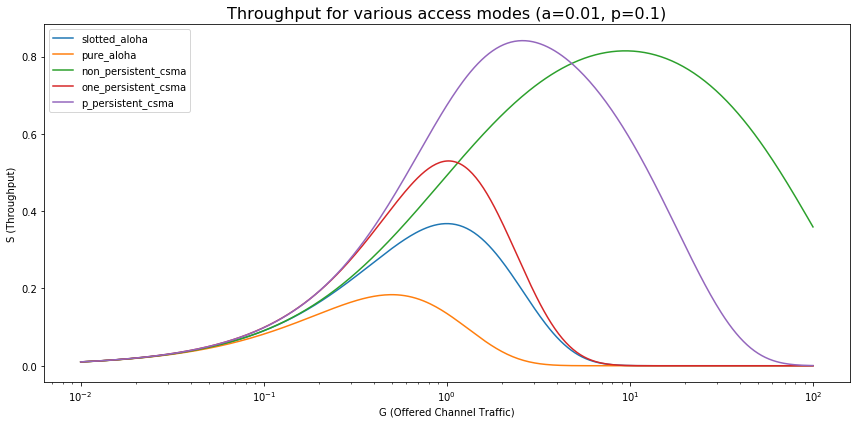

In [9]:
X = "Offered Load (G)"

fig, ax1 = plt.subplots(figsize=(12, 6), tight_layout = True)
for idx, protocol in enumerate(DF_original.columns):
    if protocol == X:
        continue
    plt.plot(DF_original[X], DF_original[protocol], label=protocol)

title = f"Throughput for various access modes (a={NORMALIZED_PROPAGATION_DELAY}, p={PROB_MEDIUM_IS_IDLE})"
ax1.set_xscale("log")
ax1.set_xlabel("G (Offered Channel Traffic)")
ax1.set_ylabel("S (Throughput)")
ax1.set_title(title, fontsize=16)
plt.legend()
plt.show()

## Plot New Graph (a=0.05, p=0.15)

In [10]:
# New Parameters:
ERROR_MARGIN = 10E-324
NORMALIZED_PROPAGATION_DELAY = 0.05
PROB_MEDIUM_IS_IDLE = 0.15 # Prob to transmit

In [11]:
if SAVE_TO_CSV:
    count = 0
    X = "Offered Load (G)"
    
    DF_new = pd.DataFrame()
    DF_new[X], NO_OF_DATAPOINTS = generate_log_datapoints(step=0.01, min_=0.01, limit_=100)
    DF_new["slotted_aloha"] = DF_new[X].apply(lambda x : slotted_aloha(x))
    DF_new["pure_aloha"] = DF_new[X].apply(lambda x : pure_aloha(x))
    DF_new["non_persistent_csma"] = DF_new[X].apply(lambda x : non_persistent_csma(x, NORMALIZED_PROPAGATION_DELAY))
    DF_new["one_persistent_csma"] = DF_new[X].apply(lambda x : one_persistent_csma(x, NORMALIZED_PROPAGATION_DELAY))
    DF_new["p_persistent_csma"] = DF_new[X].apply(lambda x : p_persistent_csma(x, NORMALIZED_PROPAGATION_DELAY, PROB_MEDIUM_IS_IDLE))

    DF_new.to_csv(NEW_GRAPH_CSV_PATH, index=False)
else:
    try:
        DF_new = pd.read_csv(NEW_GRAPH_CSV_PATH)
    except:
        raise SystemExit("CSV file not available")
    
DF_new

[2020-04-03 04:07:11] 0.0% completed	| G = 0.01	| 0.009966258672163794
[2020-04-03 04:16:34] 9.98% completed	| G = 0.02512	| 0.02490332636821763
[2020-04-03 04:27:20] 19.95% completed	| G = 0.0631	| 0.061677521830194725
[2020-04-03 04:39:47] 29.93% completed	| G = 0.15849	| 0.14880085505914925
[2020-04-03 04:53:56] 39.9% completed	| G = 0.39811	| 0.3308855030927758
[2020-04-03 05:09:40] 49.88% completed	| G = 1.0	| 0.5884549174909113
[2020-04-03 05:26:09] 59.85% completed	| G = 2.51189	| 0.710551877937035
[2020-04-03 05:42:45] 69.83% completed	| G = 6.30957	| 0.5588995005382142
[2020-04-03 05:58:30] 79.8% completed	| G = 15.84893	| 0.2162676139638792
[2020-04-03 06:11:50] 89.78% completed	| G = 39.81072	| 0.011333157411714983
[2020-04-03 06:21:01] 99.75% completed	| G = 100.0	| 2.1674717621012864e-06


Offered Load (G)  slotted_aloha    pure_aloha  non_persistent_csma  \
0             0.01000   9.900498e-03  9.801987e-03             0.009891   
1             0.01023   1.012588e-02  1.002282e-02             0.010116   
2             0.01047   1.036095e-02  1.025304e-02             0.010351   
3             0.01072   1.060570e-02  1.049261e-02             0.010595   
4             0.01096   1.084053e-02  1.072237e-02             0.010829   
..                ...            ...           ...                  ...   
396          91.20108   2.248403e-38  5.543045e-78             0.009509   
397          93.32543   2.749671e-39  8.101426e-80             0.008551   
398          95.49926   3.200357e-40  1.072499e-81             0.007671   
399          97.72372   3.541014e-41  1.283085e-83             0.006863   
400         100.00000   3.720076e-42  1.383897e-85             0.006125   

     one_persistent_csma  p_persistent_csma  
0           9.989036e-03           0.009966  
1           1.021850e-02           0.010195  
2           1.045793e-02           0.010433  
3           1.070732e-02           0.010681  
4           1.094672e-02           0.010919  
..                   ...                ...  
396         1.785083e-41           0.000008  
397         1.800399e-42           0.000006  
398         1.719769e-43           0.000004  
399         1.553863e-44           0.000003  
400         1.326256e-45           0.000002  

[401 rows x 6 columns]

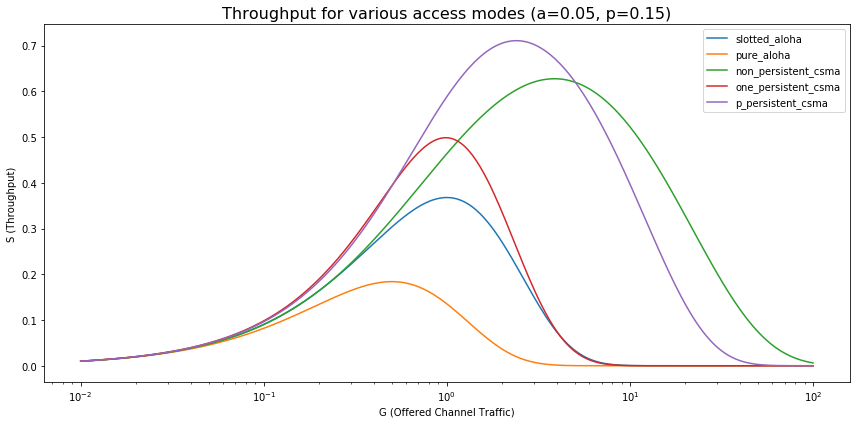

In [12]:
X = "Offered Load (G)"

fig, ax1 = plt.subplots(figsize=(12, 6), tight_layout = True)
for idx, protocol in enumerate(DF_new.columns):
    if protocol == X:
        continue
    plt.plot(DF_new[X], DF_new[protocol], label=protocol)

title = f"Throughput for various access modes (a={NORMALIZED_PROPAGATION_DELAY}, p={PROB_MEDIUM_IS_IDLE})"
ax1.set_xscale("log")
ax1.set_xlabel("G (Offered Channel Traffic)")
ax1.set_ylabel("S (Throughput)")
ax1.set_title(title, fontsize=16)
plt.legend()
plt.show()

## Interactive Graphs

In [13]:
DF_original = pd.read_csv(ORIGINAL_GRAPH_CSV_PATH)
DF_new = pd.read_csv(NEW_GRAPH_CSV_PATH)

In [14]:
X = "Offered Load (G)"

fig = go.Figure()
for idx, protocol in enumerate(DF_original.columns):
    if protocol == X:
        continue
    fig.add_trace(go.Scatter(
        name=protocol,
        x=DF_original[X],
        y=DF_original[protocol],
        mode="lines",
        showlegend=True))

title = f"Throughput for various access modes (a=0.01, p=0.1)"
fig.update_layout(xaxis_type="log",
                  title={'text': title,
                         'y':0.9,
                         'x':0.45,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  xaxis_title="G (Offered Channel Traffic)",
                  yaxis_title="S (Throughput)",)
fig.show()

In [15]:
X = "Offered Load (G)"

fig = go.Figure()
for idx, protocol in enumerate(DF_new.columns):
    if protocol == X:
        continue
    fig.add_trace(go.Scatter(
        name=protocol,
        x=DF_new[X],
        y=DF_new[protocol],
        mode="lines",
        showlegend=True))

title = f"Throughput for various access modes (a={NORMALIZED_PROPAGATION_DELAY}, p={PROB_MEDIUM_IS_IDLE})"
fig.update_layout(xaxis_type="log",
                  title={'text': title,
                         'y':0.9,
                         'x':0.45,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  xaxis_title="G (Offered Channel Traffic)",
                  yaxis_title="S (Throughput)",)
fig.show()